In [1]:
!pip install pyarrow
!wget https://www.wfonts.com/download/data/2014/06/01/simhei/simhei.zip
!unzip simhei.zip

    100% |████████████████████████████████| 11.6MB 3.8MB/s 
--2018-12-17 01:45:00--  https://www.wfonts.com/download/data/2014/06/01/simhei/simhei.zip
Resolving www.wfonts.com (www.wfonts.com)... 104.225.219.210
Connecting to www.wfonts.com (www.wfonts.com)|104.225.219.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10546298 (10M) [application/octetstream]
Saving to: ‘simhei.zip’

simhei.zip          100%[===================>]  10.06M  34.6MB/s    in 0.3s    

2018-12-17 01:45:00 (34.6 MB/s) - ‘simhei.zip’ saved [10546298/10546298]

Archive:  simhei.zip
  inflating: chinese.simhei.ttf      
  inflating: SimHei.ttf              
  inflating: sharefonts.net.txt      


In [2]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [3]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from sklearn.model_selection import train_test_split
import numpy as np

print(tf.VERSION)
print(tf.keras.__version__)

1.12.0
2.1.6-tf


In [4]:
df = pd.read_parquet('/gdrive/My Drive/typo-detection/article_contents.snappy.parquet')[['article_id', 'main_content']].set_index('article_id')
df = df[~df.main_content.isnull()]
df.head()

main_content
article_id                                                   
3           英超曼聯今晨主場出擊，只能與剛剛上任為車路士的領隊軒迪克打和0:0，近8場未嘗勝績，備受批評...
6           港超勁旅南華宣布羅致前厄瓜多爾國腳菲力斯保耶（Felix Borja），簽約一年半；足主張廣...
7           阿仙奴走出日前慘吞修咸頓4球的陰影，今晨主場憑奧斯爾一傳一射，以2：0氣走般尼茅夫，以19戰...
9           英超今晨其餘賽事，熱刺憑前鋒孫興愍89分鐘的入球，以２：1作客反勝屈福特，暫時升上聯賽榜第3...
10          352場英超上陣，170場不失球，令阿仙奴門將施治打破前英格蘭國腳占士紀錄，成為英超史上不失...

In [5]:
# Train test split articles
train, test = train_test_split(df, test_size=0.2, shuffle=False)
train.shape, test.shape

((174664, 1), (43667, 1))

In [6]:
TRAIN_SIZE = -1
TEST_SIZE = -1

# Run tokenizer on char level for training data, support 100k + tokens, with oov token (from keras)
tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=True, oov_token='<oov>', split='')
tokenizer.fit_on_texts(train[:TRAIN_SIZE].main_content)
len(tokenizer.index_word), tokenizer.word_index['<oov>']

(12496, 1)

In [0]:
# Split article to 64 chars each for both training and testing
# Keras Articles -> Chars -> Indices -> Pad to 64 chars

SEQ_LENGTH = 64
ERROR_PROB = 1/64.

def generate_dataset(df, error_prob):
  seqs = tokenizer.texts_to_sequences(df.main_content)
  padded_seqs = tf.keras.preprocessing.sequence.pad_sequences(seqs, maxlen=SEQ_LENGTH, padding='post', truncating='post', value=0.0)
  
  index_word_count = [(tokenizer.word_index[k], v) for k, v in tokenizer.word_counts.items()]
  index_word_count.append((0, sum([x[1] for x in index_word_count]) / (error_prob) * (1 - error_prob)))
  
  choice = np.array([x[0] for x in index_word_count])

  p = np.array([x[1] for x in index_word_count])
  p = p / np.sum(p)
  
  # for each sequence, randomly replace the index
  random_error = np.random.choice(choice, padded_seqs.shape, p=p)
  random_error_mask = (random_error > 0).astype(int)
  
  inp = padded_seqs * (1-random_error_mask) + random_error
  out = random_error_mask
  
  return inp, out

In [8]:
train_inp, train_out = generate_dataset(train[:TRAIN_SIZE], ERROR_PROB)
test_inp, test_out = generate_dataset(test[:TEST_SIZE], ERROR_PROB)

train_inp.shape, train_out.shape, test_inp.shape, test_out.shape

((174663, 64), (174663, 64), (43666, 64), (43666, 64))

In [0]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager
import numpy as np
import seaborn as sns

def visualize(inp, truth, pred, display_rows=5):
  font_files = font_manager.findSystemFonts(fontpaths='/content')
  font_list = font_manager.createFontList(font_files)
  font_manager.fontManager.ttflist.extend(font_list)
  sns.set_style("darkgrid",{"font.sans-serif":['simhei', 'Arial']})

  fig, ax = plt.subplots(figsize=(20,display_rows / 3))
  sns.heatmap(pred[:display_rows], \
    annot=np.array([[c for c in row[::2]] for row in tokenizer.sequences_to_texts(inp)[:display_rows]]), \
    fmt='', cmap="YlGnBu", ax=ax, vmin=0, vmax=1)

  fig, ax = plt.subplots(figsize=(20,display_rows / 3))
  sns.heatmap(truth[:display_rows], \
    annot=np.array([[c for c in row[::2]] for row in tokenizer.sequences_to_texts(inp)[:display_rows]]), \
    fmt='', cmap="YlGnBu", ax=ax, vmin=0, vmax=1)

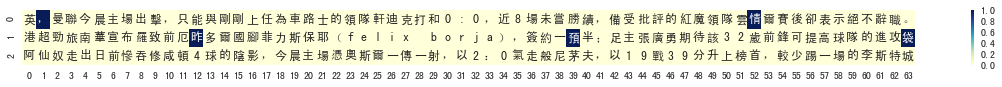

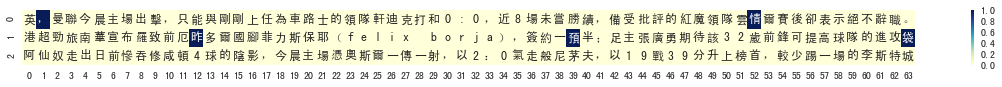

In [10]:
visualize(train_inp, train_out, train_out, display_rows=3)

In [16]:
EMBEDDING_SIZE = 64
GRU_SIZE = EMBEDDING_SIZE // 2

def build_model():
#   model = models.Sequential()
  inp = layers.Input((SEQ_LENGTH,), dtype='int32')
  emb = layers.Embedding(len(tokenizer.index_word) + 1, EMBEDDING_SIZE, input_length=SEQ_LENGTH)(inp)
  
  gru = layers.Bidirectional(layers.CuDNNGRU(GRU_SIZE, return_sequences=True))(emb)
  gru = layers.Bidirectional(layers.CuDNNGRU(GRU_SIZE, return_sequences=True))(gru)
  
  final = layers.Add()([gru, emb])
#   gru = layers.CuDNNGRU(GRU_SIZE, return_sequences=True)(gru)
  
  pred = layers.Dense(1, activation='sigmoid')(final)
  out = layers.Flatten()(pred)
  
  model = models.Model(inputs=inp, outputs=out)
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mae', 'acc'])
  return model
  
model = build_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 64)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 64, 64)       799808      input_4[0][0]                    
__________________________________________________________________________________________________
bidirectional_6 (Bidirectional) (None, 64, 64)       18816       embedding_3[0][0]                
__________________________________________________________________________________________________
bidirectional_7 (Bidirectional) (None, 64, 64)       18816       bidirectional_6[0][0]            
__________________________________________________________________________________________________
add_2 (Add

In [0]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from tensorflow.keras.callbacks import Callback

class roc_callback(Callback):
    def __init__(self, training_data, validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]


    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        roc = roc_auc_score(self.y, y_pred)
        prec = precision_score(np.ndarray.flatten((self.y).astype(int)), np.ndarray.flatten((y_pred > 0.5).astype(int)))
        recall = recall_score(np.ndarray.flatten((self.y).astype(int)), np.ndarray.flatten((y_pred > 0.5).astype(int)))
        
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val > 0.5)
        prec_val = precision_score(np.ndarray.flatten((self.y_val).astype(int)), np.ndarray.flatten((y_pred_val > 0.5).astype(int)))
        recall_val = recall_score(np.ndarray.flatten((self.y_val).astype(int)), np.ndarray.flatten((y_pred_val > 0.5).astype(int)))
        
        print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,4)),str(round(roc_val,4))),end=100*' '+'\n')
        print('\rprecision: %s - precision_val: %s' % (str(round(prec,4)),str(round(prec_val,4))),end=100*' '+'\n')
        print('\rrecall: %s - recall_val: %s' % (str(round(recall,4)),str(round(recall_val,4))),end=100*' '+'\n')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

# model.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks=[roc_callback(training_data=(X_train, y_train),validation_data=(X_test, y_test))])

In [18]:
# train_inp.shape, train_out.shape
X_train, X_val, y_train, y_val = train_test_split(train_inp, train_out, test_size=0.2, shuffle=False)

model.fit( \
          X_train, \
          y_train, \
          validation_data=(X_val, y_val),
          batch_size=64, \
          epochs=1000, \
          callbacks=[roc_callback(training_data=(X_train, y_train), validation_data=(X_val, y_val))],
         )

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 139730 samples, validate on 34933 samples
Epoch 1/1000
roc-auc: 0.7547 - roc-auc_val: 0.5421                                                                                                    
precision: 0.8155 - precision_val: 0.8066                                                                                                    
recall: 0.0827 - recall_val: 0.0847                                                                                                    
139730/139730 [==============================] - 200s 1ms/step - loss: 0.0808 - mean_absolute_error: 0.0330 - acc: 0.9842 - val_loss: 0.0685 - val_mean_absolute_error: 0.0265 - val_acc: 0.9853
Epoch 2/1000
roc-auc: 0.8556 - roc-auc_val: 0.5945                                                                                                    
precision: 0.8563 - precision_val: 0.8368                                                                                                    
recall: 0.1864 - recall_val: 0.189

KeyboardInterrupt: ignored

In [0]:
test_pred = model.predict(test_inp)

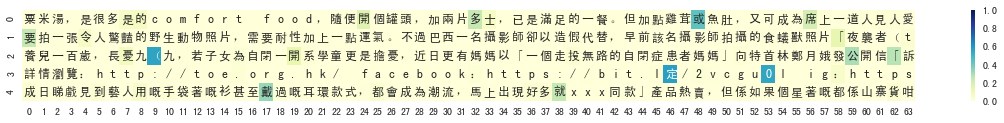

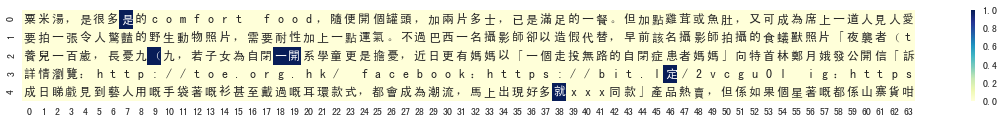

In [20]:
visualize(test_inp, test_out, test_pred)

In [0]:
raw_test_inp, raw_test_out = generate_dataset(test[:TEST_SIZE], error_prob=0.001)
raw_test_pred = model.predict(raw_test_inp)

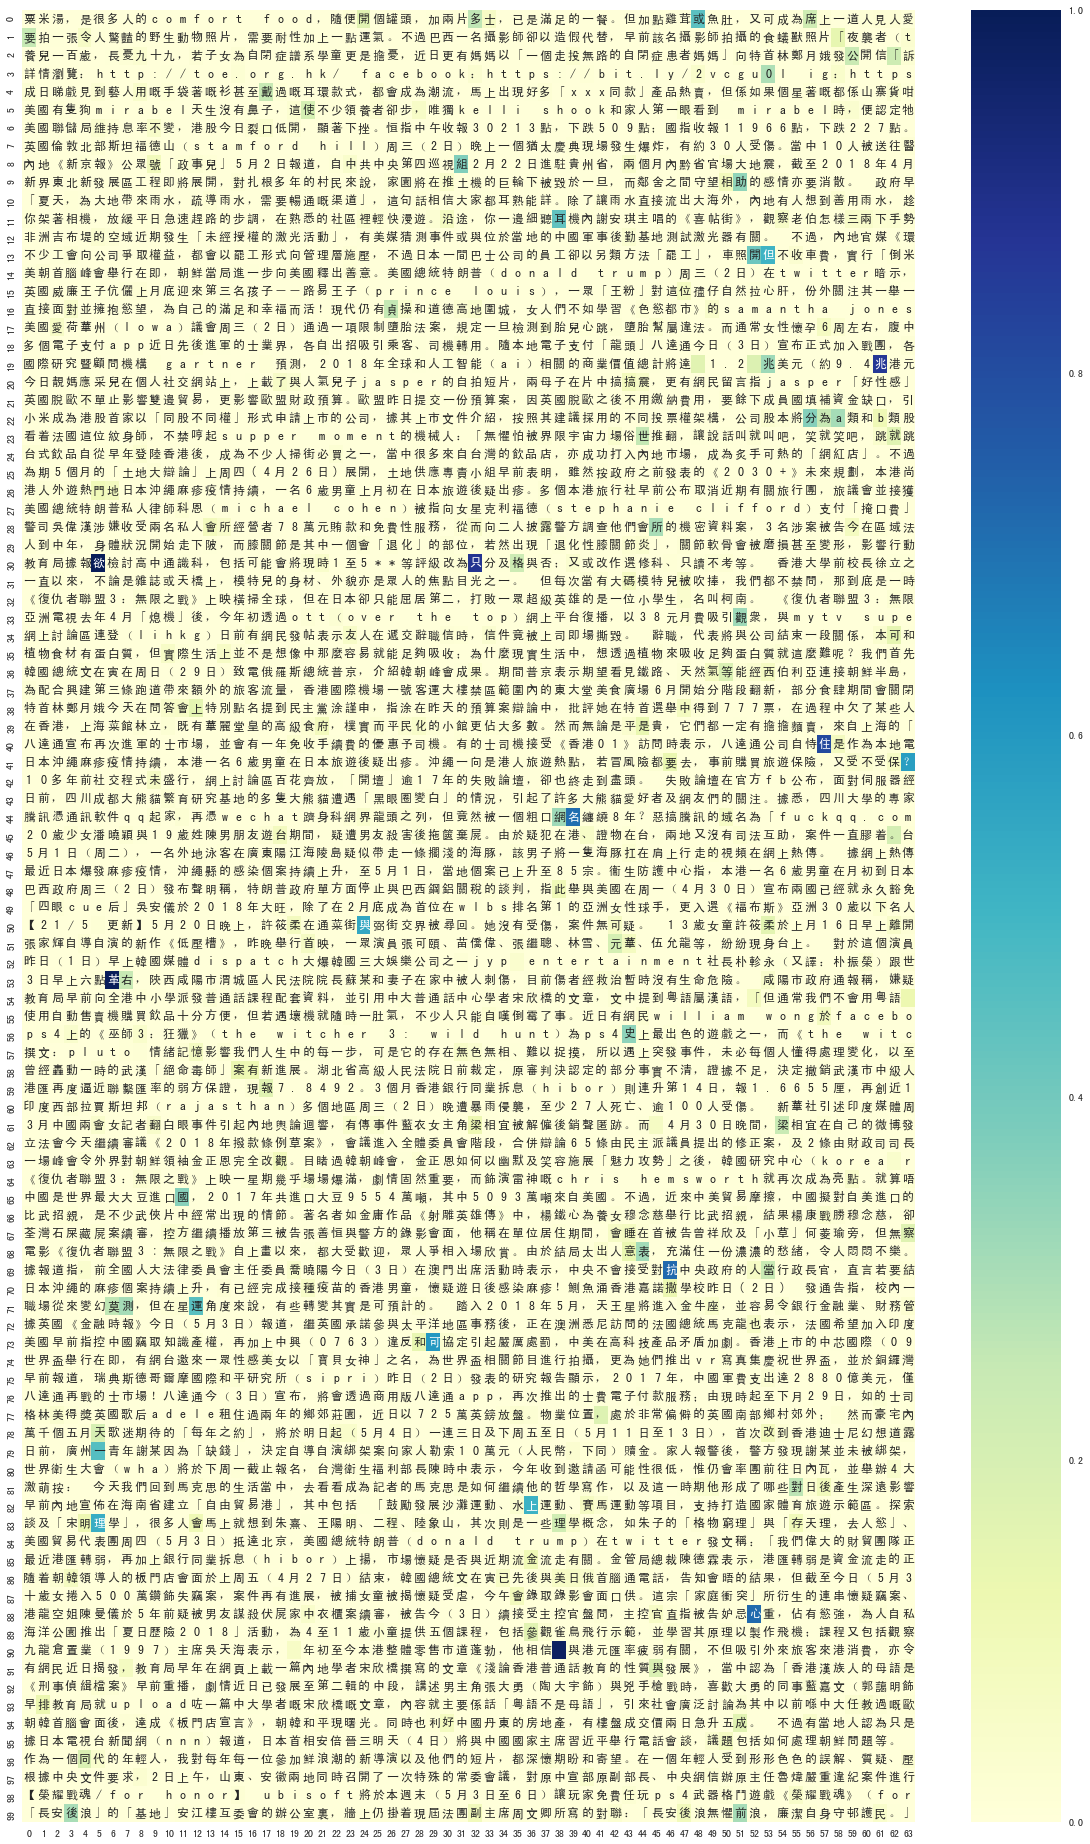

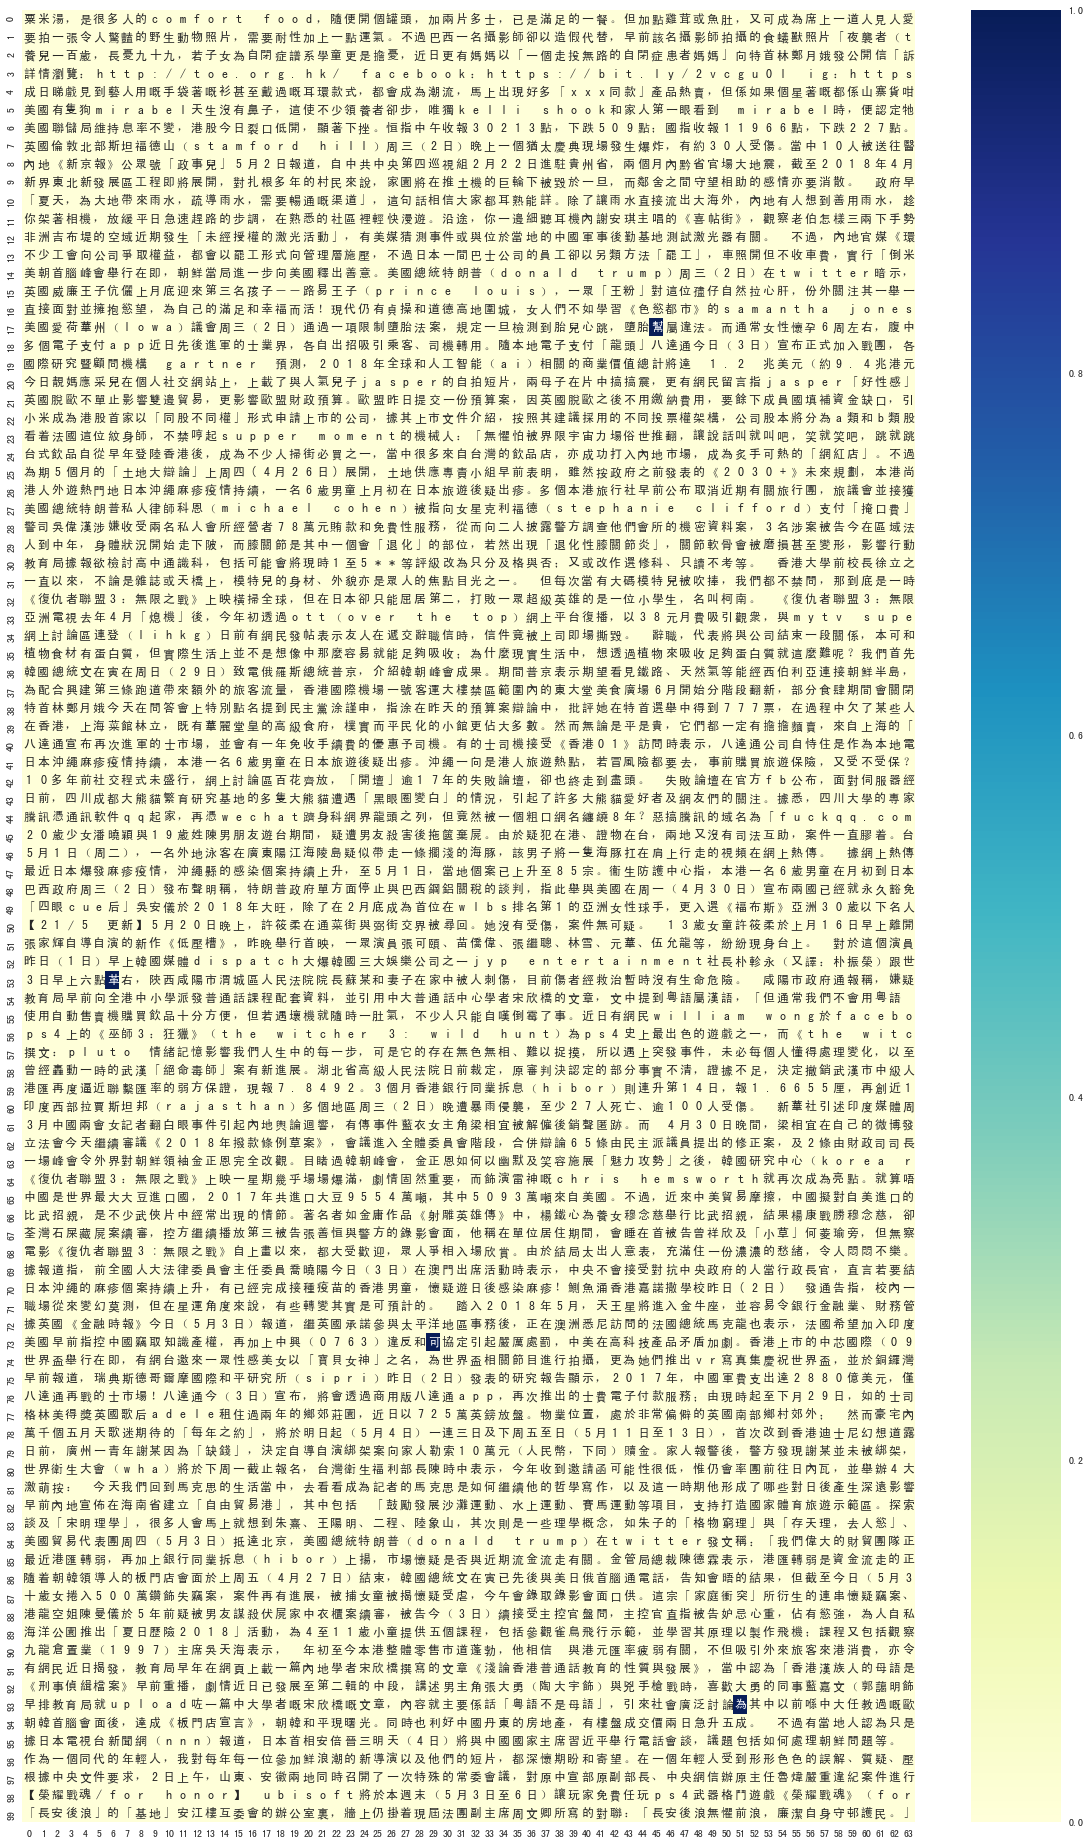

In [22]:
visualize(raw_test_inp, raw_test_out, raw_test_pred, display_rows=100)

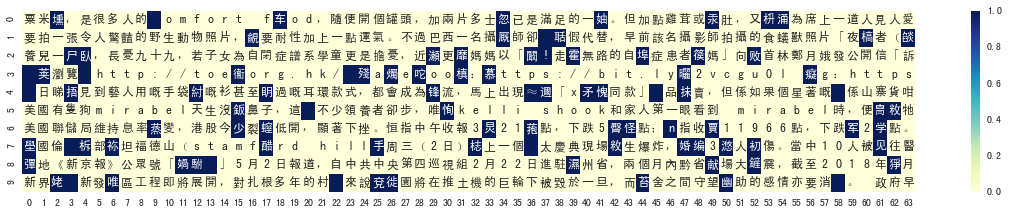

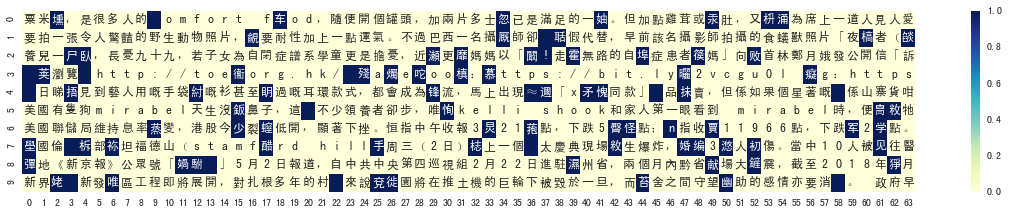

In [0]:
# Improvement
# Better corpus
# Masked Loss Function (?)
# Inverse Log Sampling
# Better Typo Models
# Concat Char Level pretrainined word vectors
# Dropout and Regularization